# Generating PID controller data
This series of notebooks explores the idea of emulating PID controller behavior with an LSTM. This first notebook is used to tune a PID controller and generate data from the TCLab for use in training the LSTM. The LSTM can then be used in place of the PID controller (or any other controller it is trained on), or used to evaluate the PID controller performance for anomaly detection.

In [1]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

TCLab version 0.4.9
Arduino Leonardo connected on port COM5 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
TCLab disconnected successfully.


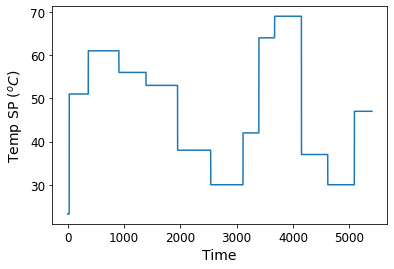

In [3]:
##### Set up run parameters #####

# Run time in minutes
run_time = 90.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with tclab.TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

# vary temperature setpoint
end = 30 # leave 1st 30 seconds of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

In [4]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in range(loops):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D,iae))
        

-0.00 14393.40
5059.5  30.00  29.73  19.70   1.63  18.07  -0.00 14393.67
5060.5  30.00  29.79  19.33   1.24  18.09  -0.00 14393.87
5061.5  30.00  29.82  19.15   1.05  18.10  -0.00 14394.05
5062.5  30.00  29.70  19.95   1.82  18.13   0.00 14394.35
5063.5  30.00  29.86  19.00   0.86  18.14  -0.00 14394.50
5064.5  30.00  29.76  19.59   1.43  18.16   0.00 14394.73
5065.5  30.00  29.66  20.20   2.02  18.19   0.00 14395.07
5066.5  30.00  29.70  20.03   1.82  18.21  -0.00 14395.37
5067.5  30.00  29.70  20.06   1.82  18.23  -0.00 14395.68
5068.5  30.00  29.82  19.30   1.05  18.25  -0.00 14395.85
5069.5  30.00  29.86  19.12   0.86  18.26  -0.00 14396.00
5070.5  30.00  29.92  18.73   0.47  18.27  -0.00 14396.07
5071.5  30.00  29.92  18.74   0.47  18.27  -0.00 14396.15
5072.5  30.00  29.92  18.75   0.47  18.28  -0.00 14396.23
5073.5  30.00  29.92  18.75   0.47  18.28  -0.00 14396.31
5074.5  30.00  29.92  18.76   0.47  18.29  -0.00 14396.39
5075.5  30.00  29.92  18.76   0.47  18.30  -0.00 14396.46

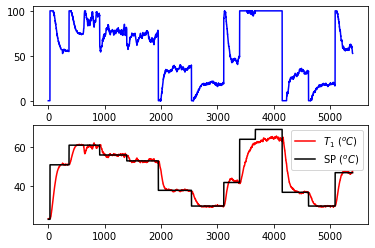

In [6]:
# Save csv file
data = pd.DataFrame()
data['Q1'] = Q1
data['T1'] = T1
data['Tsp'] = Tsp1
data.to_csv('PID_train_data.csv',index=False)

# Plot
plt.subplot(2,1,1)
plt.plot(data['Q1'],'b-',label='$Q_1$ (%)')
plt.subplot(2,1,2)
plt.plot(data['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(data['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig('PID_train.png');